## janesick_nature_comms_2023, scRNA

In [9]:
import time
from pathlib import Path
proj_name = "janesick_nc_2023_dev"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/janesick_nature_comms_2023/"
data_dir = Path(data_dir)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

'Jun05-2112'

### FRP

In [2]:
import scanpy as sc
import pandas as pd

from pathlib import Path
frp_path = Path("../data/janesick_nature_comms_2023/scRNA_frp/").expanduser()
annot_path = Path("../data/janesick_nature_comms_2023/GSE243275_Barcode_Cell_Type_Matrices.xlsx").expanduser()

# Load data
frp_adata = sc.read_10x_h5(frp_path / "Chromium_FFPE_Human_Breast_Cancer_Chromium_FFPE_Human_Breast_Cancer_count_sample_filtered_feature_bc_matrix.h5")

celltype_df = pd.read_excel(
    annot_path,
    sheet_name="scFFPE-Seq",
    index_col=0,
)



/opt/anaconda3/envs/concord/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
# concat xenium_cell_info, xenium_celltype_df to xenium_adata.obs
frp_adata.obs = frp_adata.obs.join(celltype_df, how='left')
frp_adata.obs


,Annotation
AAACAAGCAAACGGGA-1,Stromal
AAACAAGCAAATAGGA-1,Macrophages 1
AAACAAGCAAATGACT-1,NaN
AAACAAGCAACAAGTT-1,Perivascular-Like
AAACAAGCAACCATTC-1,Myoepi ACTA2+
...,...
TTTGTGAGTGGTTACT-1,DCIS 2
TTTGTGAGTGTTCCAG-1,Stromal
TTTGTGAGTTACTTCT-1,Prolif Invasive Tumor
TTTGTGAGTTGTCATA-1,DCIS 1


In [10]:
# Normalize visium_adata
frp_adata.layers['counts'] = frp_adata.X.copy()
sc.pp.normalize_total(frp_adata, target_sum=1e4)
# log transform
sc.pp.log1p(frp_adata)
# PCA and UMAP
n_latent = 30
sc.pp.pca(frp_adata, n_comps=n_latent, svd_solver='arpack')
sc.pp.neighbors(frp_adata, n_neighbors=15, n_pcs=n_latent)
sc.tl.umap(frp_adata, min_dist=0.1, n_components=2)

/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: divide by zero encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: overflow encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: invalid value encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: divide by zero encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: overflow encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/opt/anaconda3/envs/concord/lib/python3.12/site-packages/sklearn/utils/sparsefuncs.py:737: Runtime

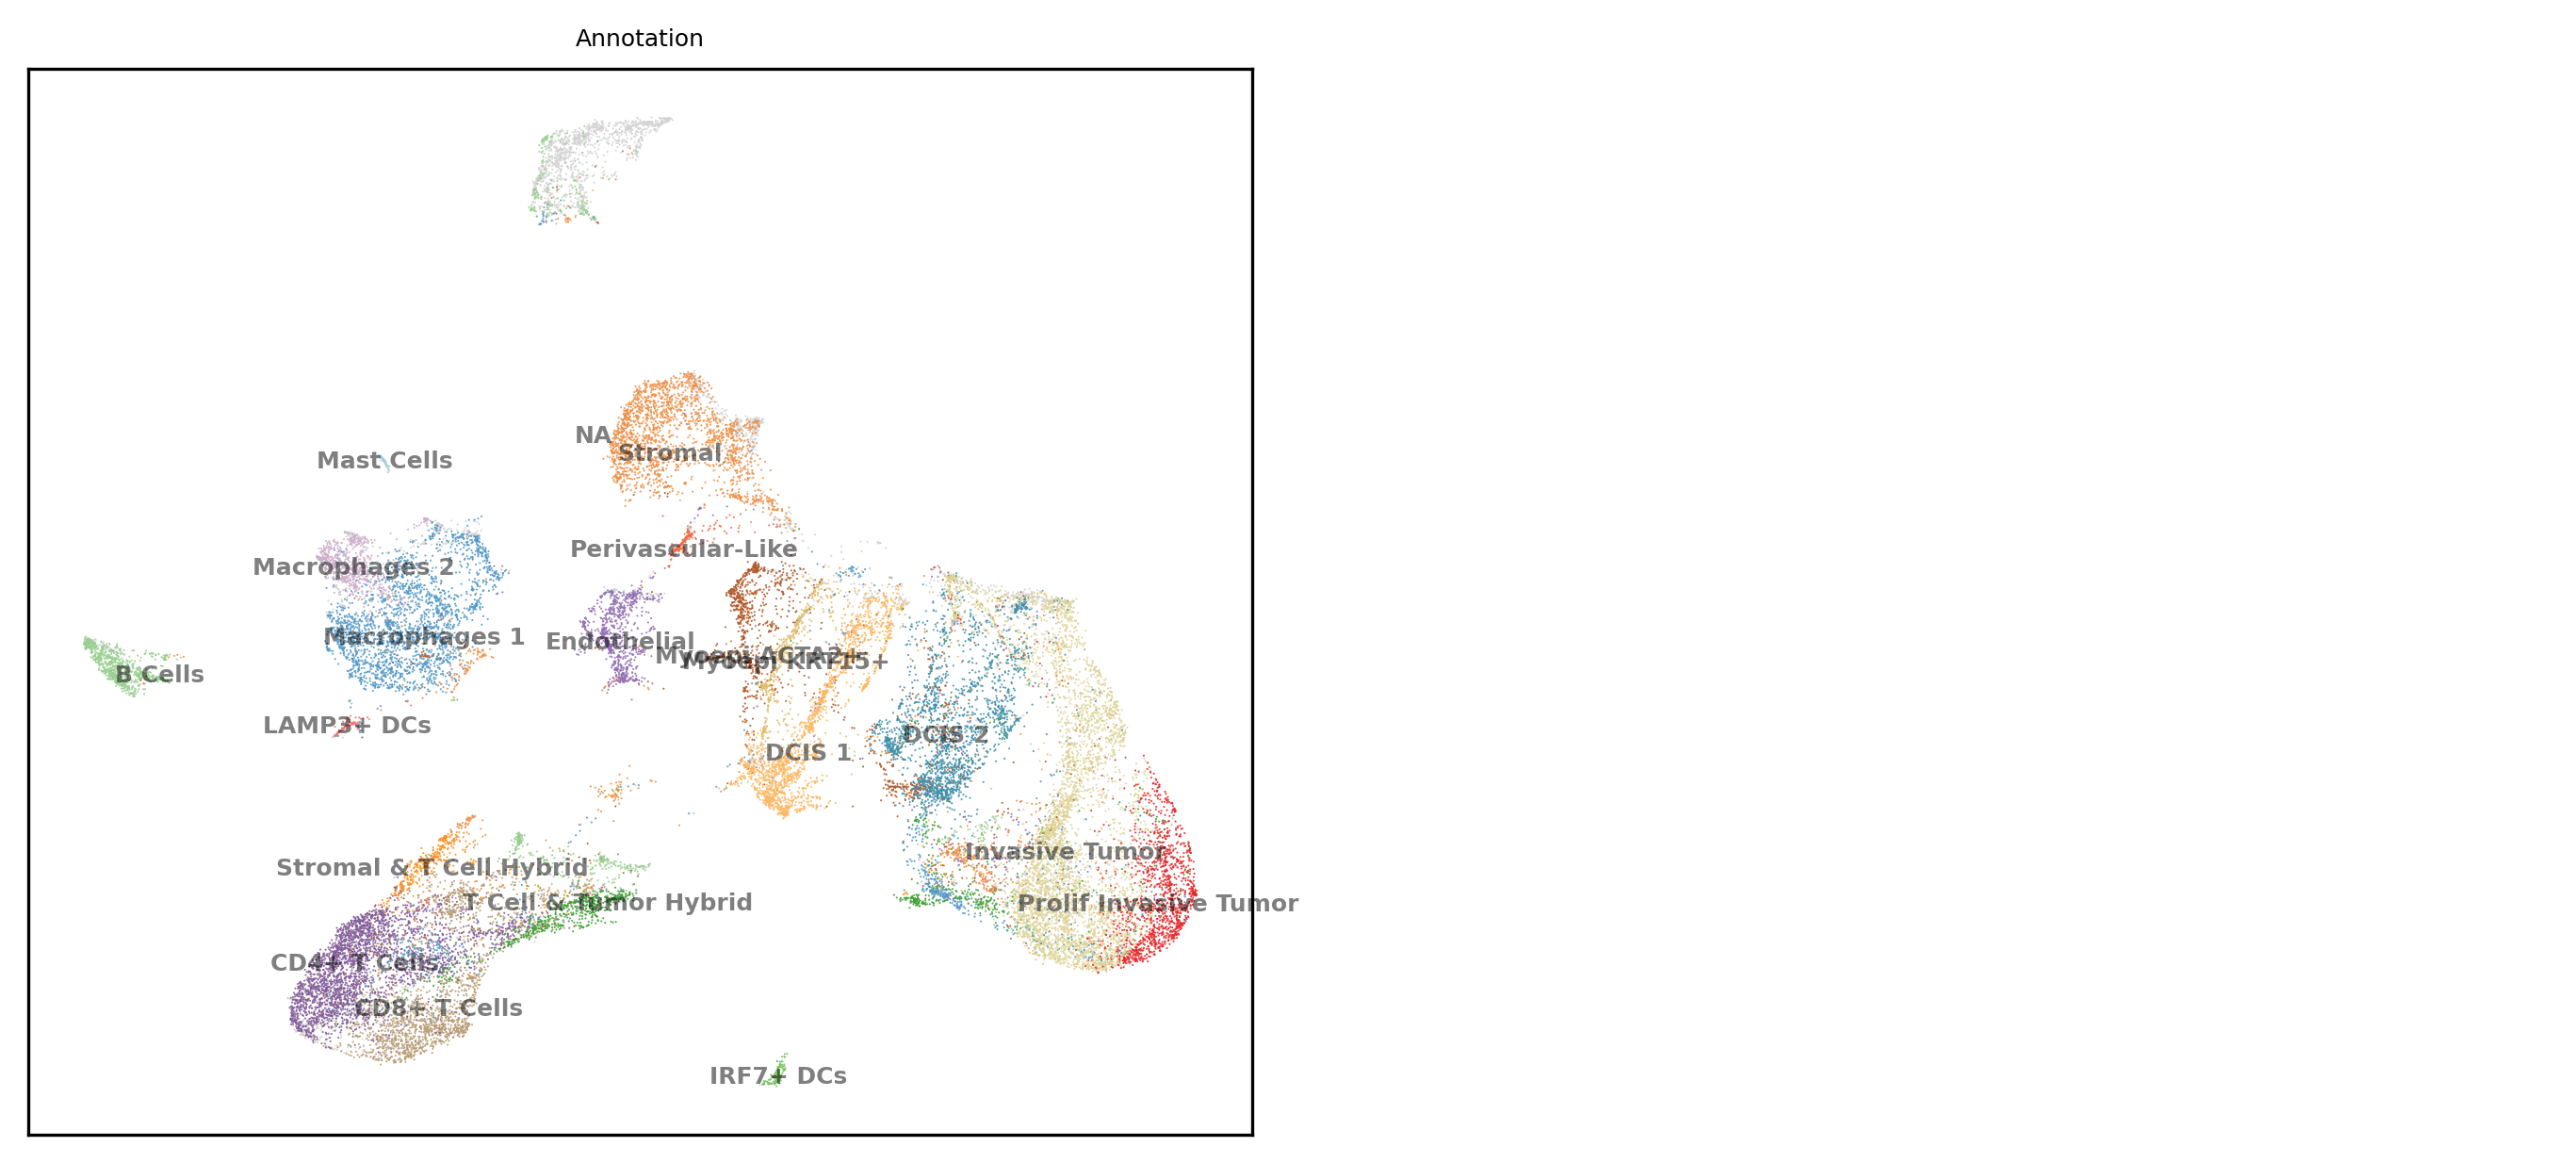

In [11]:
import concord as ccd
_, _, ct_pal = ccd.pl.get_color_mapping(frp_adata, 'Annotation', pal='Paired', seed=1)
pal = {'Annotation':ct_pal}
show_basis = f'X_umap'
show_cols = ['Annotation']
ccd.pl.plot_embedding(
    frp_adata, show_basis, show_cols, figsize=(9,4), dpi=300, ncols=2,  font_size=6, point_size=1, legend_loc='on data',
    pal=pal,
    save_path=save_dir / f"frp_embeddings_{show_basis}_{file_suffix}.png"
)

In [12]:
import concord as ccd
cur_ccd = ccd.Concord(adata=frp_adata, 
                      latent_dim = n_latent,
                      save_dir=save_dir, # directory to save model checkpoints
                      inplace=False, # whether to modify adata in place
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
frp_adata.obsm = cur_ccd.adata.obsm.copy()
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"frp_obsm_{file_suffix}.h5")

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 0.3


Epoch 0 Training: 474it [00:10, 45.02it/s, loss=3.36]
Epoch 9 Training: 100%|██████████| 474/474 [00:10<00:00, 46.03it/s, loss=3.34]


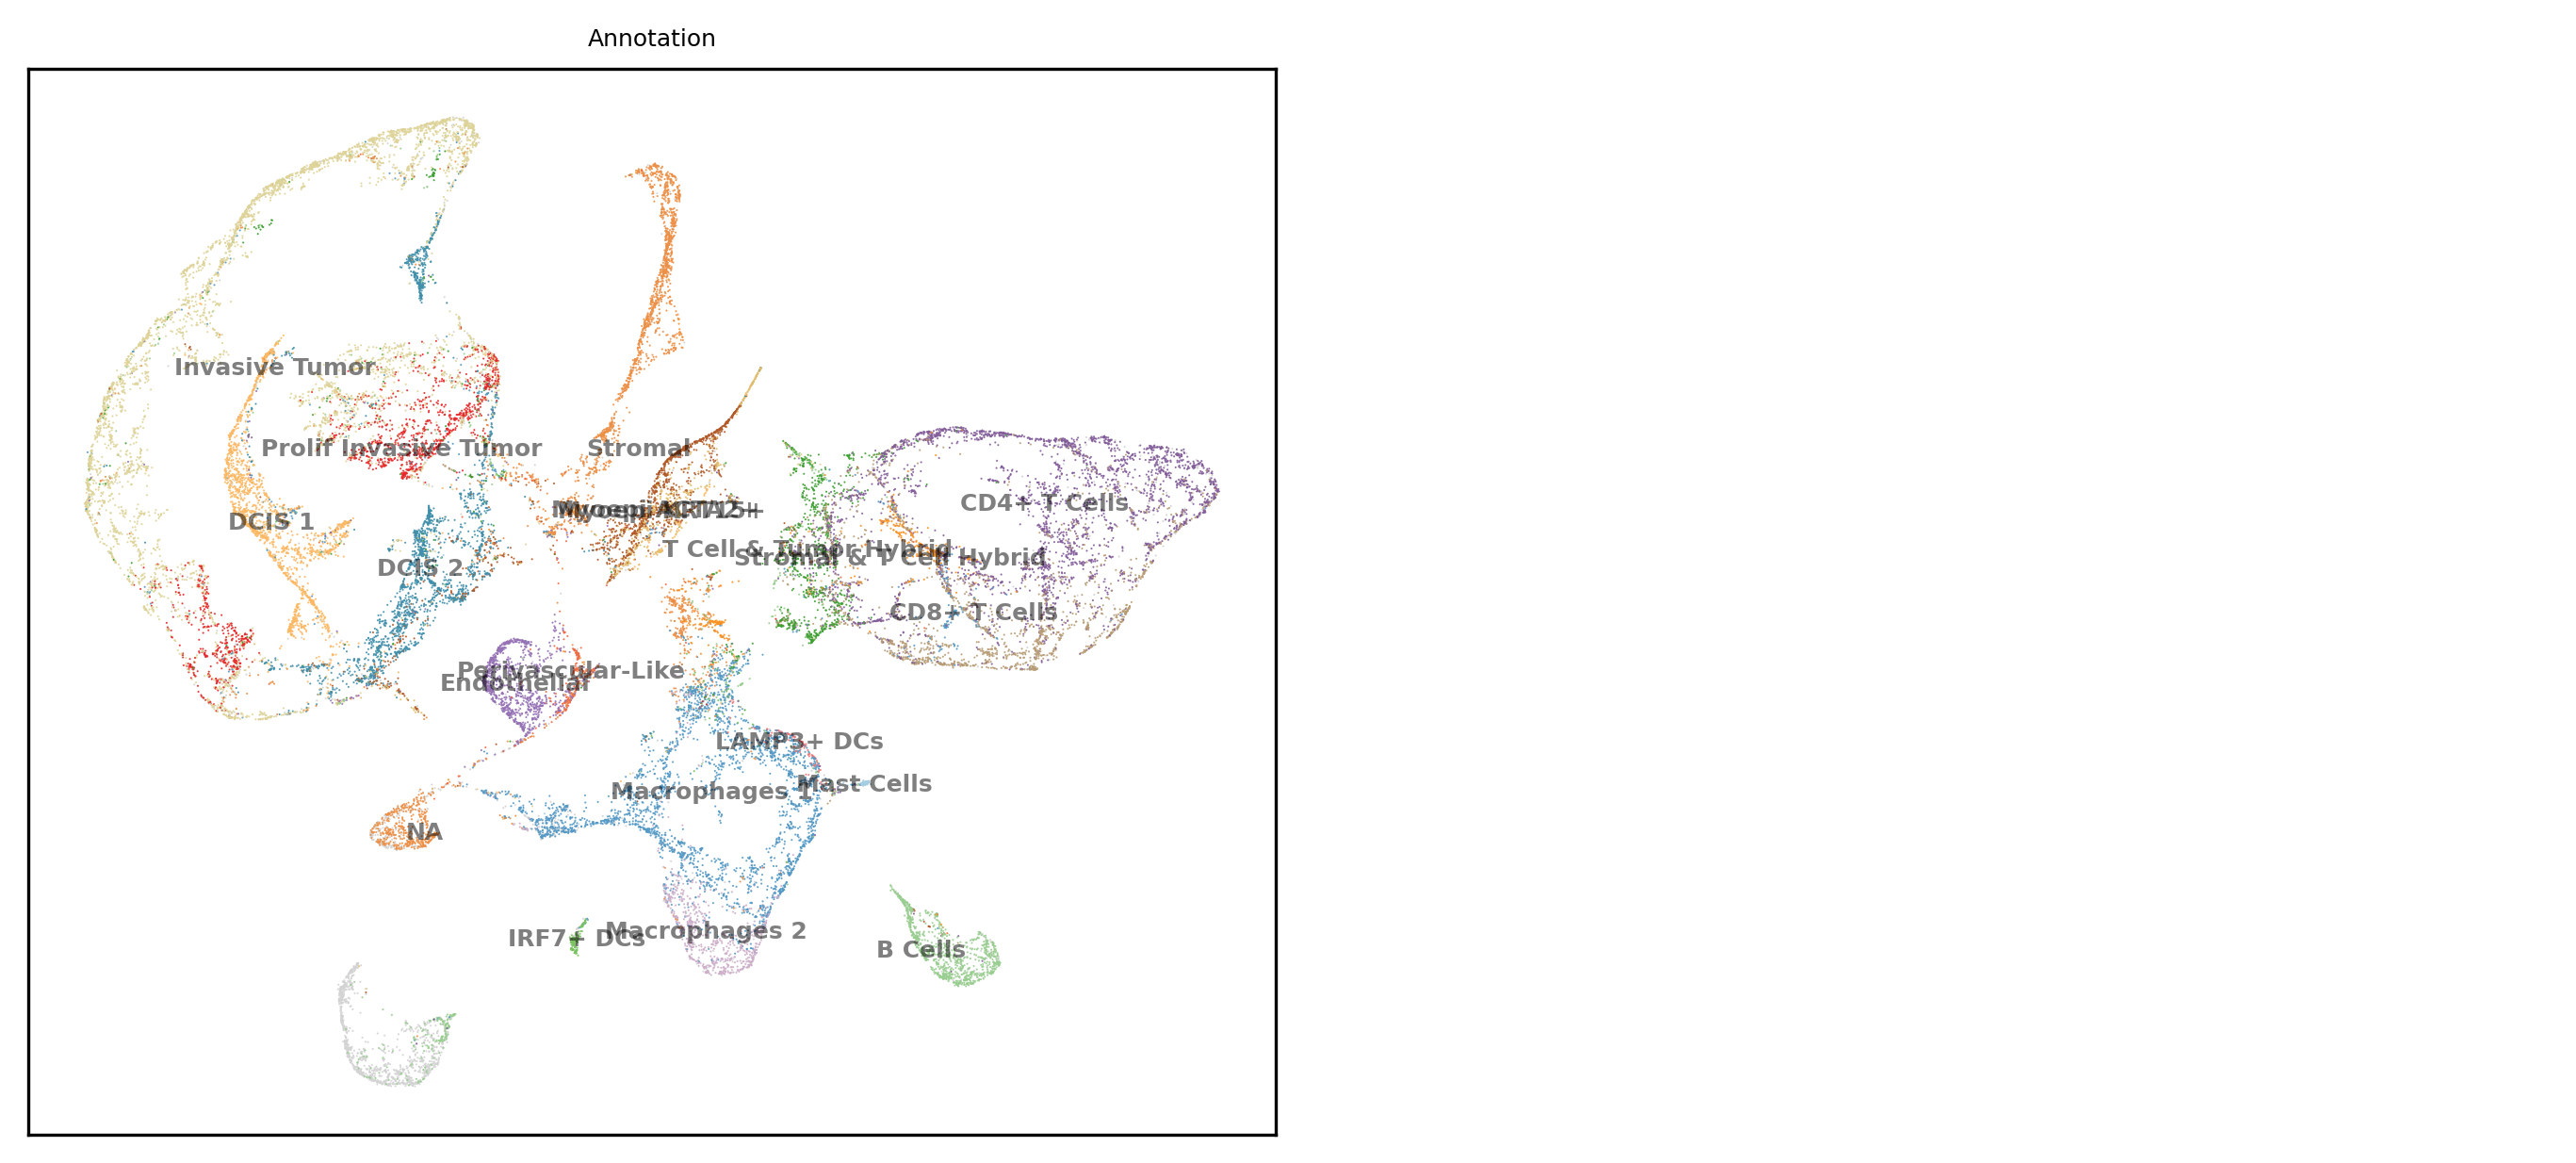

In [15]:
# compute umap
ccd.ul.run_umap(frp_adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean')
show_basis = f'{output_key}_UMAP'
show_cols = ['Annotation']
ccd.pl.plot_embedding(
    frp_adata, show_basis, show_cols, figsize=(9,4), dpi=300, ncols=2, font_size=6, point_size=1, legend_loc='on data',
    pal=pal,
    save_path=save_dir / f"frp_embeddings_{show_basis}_{file_suffix}.png"
)

In [13]:
frp_adata.shape

(30365, 18082)

In [ ]:
frp_adata.obs_names = "frp_" + frp_adata.obs_names.astype(str)
frp_adata.write_h5ad(data_dir / f"frp_adata_{file_suffix}.h5ad")
print(f"Saved frp_adata to {data_dir / f'frp_adata_{file_suffix}.h5ad'}")
ccd.ul.anndata_to_viscello(frp_adata, data_dir / f"cello_frp_{proj_name}_{file_suffix}", project_name = proj_name, organism='hsa')
print(f"Saved viscello to {data_dir / f'cello_frp_{proj_name}_{file_suffix}.h5ad'}")


Saved frp_adata to ../data/janesick_nature_comms_2023/frp_adata_Jun05-2112.h5ad
